# BorrowCup Data Analysis

### A bit about BorrowCup
BorrowCup is a students’ initiative towards sustainable living funded by Monash University. According to a statistic, about 1 million disposable coffee cups are used across Monash University Melbourne campuses every year. This initiative aims to reduce that number by allowing students and staff to use BorrowCup – a keep cup which can be borrowed from a cafe and returned in dedicated bins spread across campus at their convenience.

### Aim: 
- #### Cups Usage Analysis
    Number of times cups were borrowed
- #### Return Time Analysis
    After how much time, cups were returned once borrowed
    
### Approach in brief:

 1. #### Get Data from API
 Get data from the REST API
         
 2. #### Clean data
     - Drop irrelevant information
     - Filter out the data before 22nd Jan 2020 (because Return data is 99% accurate post this date)
     - Check for duplicate rows
     - Map sale records to their return records and fabricate date-times if either one doesn't exist.
     - Get the final cleaned data
     
 3. #### Analyse data
     - Perform Return Time Analysis
     - Perform Cups Usage (Number of times cups have been used/borrowed) Analysis

`Note` 
* This code analyses the data post 22nd Jan 2020.
* Here, 'sale' and 'borrow' terms, and 'row' and 'record' terms have been used interchangeably.

### Get JSON data from the REST API

In [1]:
# installing dotenv package (run first time only)
!pip install -U python-dotenv

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import requests, pandas as pd, time
from dotenv import load_dotenv
load_dotenv()

import os
domain = os.getenv("URL")

print('Getting data... Please wait!')
startTime = time.time()

# get sale data
response = requests.get('https://' + domain + 'sale')
saleData = response.json()

print('Took', round(time.time() - startTime, 2), 'seconds to get Sale data.')
startTime = time.time()

# get return data
response = requests.get('https://' + domain + 'return')
returnData = response.json()

print('Took', round(time.time() - startTime, 2), 'seconds to get Return data.')

Getting data... Please wait!
Took 28.03 seconds to get Sale data.
Took 13.55 seconds to get Return data.


### Store sale data in a dataframe

In [3]:
# build dataframe
saleDF = pd.DataFrame.from_dict(saleData, orient='columns')
saleDF.head()

,cafe_id,cup_id,id,return_id,scanned_at,scanned_at_melbourne_date,scanned_at_melbourne_date_time,scanned_at_melbourne_time
0,105,3908879092,1,2506.0,2019-10-22T02:24:43.000Z,22/10/2019,"{'date': '22/10/2019', 'time': '1:24:43 PM'}",1:24:43 PM
1,105,1070578934,2,492.0,2019-10-22T02:25:04.000Z,22/10/2019,"{'date': '22/10/2019', 'time': '1:25:04 PM'}",1:25:04 PM
2,105,8282349427,3,NaN,2019-10-22T02:25:20.000Z,22/10/2019,"{'date': '22/10/2019', 'time': '1:25:20 PM'}",1:25:20 PM
3,105,1649441458,4,NaN,2019-10-22T02:25:59.000Z,22/10/2019,"{'date': '22/10/2019', 'time': '1:25:59 PM'}",1:25:59 PM
4,105,6428914941,5,362.0,2019-10-22T02:26:03.000Z,22/10/2019,"{'date': '22/10/2019', 'time': '1:26:03 PM'}",1:26:03 PM


### Drop irrelevant columns and rename some others

In [4]:
# drop columns
saleDF = saleDF.drop(['scanned_at', 'scanned_at_melbourne_date_time'], axis=1)

# rename
saleDF = saleDF.rename(columns={"scanned_at_melbourne_date": "sale_date", "scanned_at_melbourne_time": "sale_time", "id": "sale_id"})
saleDF.head()

,cafe_id,cup_id,sale_id,return_id,sale_date,sale_time
0,105,3908879092,1,2506.0,22/10/2019,1:24:43 PM
1,105,1070578934,2,492.0,22/10/2019,1:25:04 PM
2,105,8282349427,3,NaN,22/10/2019,1:25:20 PM
3,105,1649441458,4,NaN,22/10/2019,1:25:59 PM
4,105,6428914941,5,362.0,22/10/2019,1:26:03 PM


### Merging date and time, and converting the new column to datetime64 datatype

In [5]:
saleDF['date_time_concat'] = saleDF['sale_date'] + ' ' + saleDF['sale_time']
saleDF['date_time'] = pd.to_datetime(saleDF['date_time_concat'], dayfirst=True)
saleDF = saleDF.drop(['sale_date', 'sale_time', 'date_time_concat'], axis=1)
saleDF.head()

,cafe_id,cup_id,sale_id,return_id,date_time
0,105,3908879092,1,2506.0,2019-10-22 13:24:43
1,105,1070578934,2,492.0,2019-10-22 13:25:04
2,105,8282349427,3,NaN,2019-10-22 13:25:20
3,105,1649441458,4,NaN,2019-10-22 13:25:59
4,105,6428914941,5,362.0,2019-10-22 13:26:03


### Filter to get records post 22nd Jan

In [6]:
saleDF = saleDF[saleDF['date_time'] >= '2020/01/22 00:00:00']
saleDF = saleDF.sort_values(by='date_time', ascending = True)
saleDF.head()

,cafe_id,cup_id,sale_id,return_id,date_time
4221,104,8574643943,4252,NaN,2020-01-22 07:46:57
4222,104,2496593207,4253,6509.0,2020-01-22 07:47:50
4223,104,1590850598,4254,6255.0,2020-01-22 07:48:44
4224,104,7342150520,4255,6870.0,2020-01-22 07:49:25
4225,104,9678996946,4256,6644.0,2020-01-22 07:56:56


### Check duplicate rows

In [7]:
saleDF[saleDF.duplicated(['cafe_id', 'cup_id', 'date_time'])]

,cafe_id,cup_id,sale_id,return_id,date_time


Great! No duplicates found.

### Store return data in a dataframe

In [8]:
from pandas.io.json import json_normalize

# build dataframe
returnDF = pd.DataFrame.from_dict(json_normalize(returnData), orient='columns')
returnDF.head()

,bin_id,cafe_id,cup_id,dishwasher_id,id,scanned_at,scanned_at_melbourne_date_time.date,scanned_at_melbourne_date_time.time
0,None,NaN,5649991371,101,1,2019-10-22T04:38:31.000Z,22/10/2019,3:38:31 PM
1,None,NaN,6978535743,101,2,2019-10-22T04:38:34.000Z,22/10/2019,3:38:34 PM
2,None,NaN,4671290001,101,3,2019-10-22T04:38:35.000Z,22/10/2019,3:38:35 PM
3,None,NaN,9351307204,101,4,2019-10-22T04:38:36.000Z,22/10/2019,3:38:36 PM
4,None,NaN,2499057498,101,5,2019-10-22T04:38:38.000Z,22/10/2019,3:38:38 PM


### Drop irrelevant columns and rename some others

In [9]:
# dropping columns
# returnDF = returnDF.drop(['scanned_at', 'bin_id', 'cafe_id', 'dishwasher_id'], axis=1)
returnDF = returnDF.drop(['scanned_at', 'bin_id', 'dishwasher_id'], axis=1)

# renaming columns
returnDF = returnDF.rename(columns={"scanned_at_melbourne_date_time.date": "return_date", "scanned_at_melbourne_date_time.time": "return_time", "id": "return_id"})
returnDF.head()

,cafe_id,cup_id,return_id,return_date,return_time
0,NaN,5649991371,1,22/10/2019,3:38:31 PM
1,NaN,6978535743,2,22/10/2019,3:38:34 PM
2,NaN,4671290001,3,22/10/2019,3:38:35 PM
3,NaN,9351307204,4,22/10/2019,3:38:36 PM
4,NaN,2499057498,5,22/10/2019,3:38:38 PM


### Merging date and time, and converting the new column to datetime64 datatype

In [10]:
returnDF['date_time_concat'] = returnDF['return_date'] + ' ' + returnDF['return_time']
returnDF['date_time'] = pd.to_datetime(returnDF['date_time_concat'], dayfirst=True)
returnDF = returnDF.drop(['return_date', 'return_time', 'date_time_concat'], axis=1)
returnDF.head()

,cafe_id,cup_id,return_id,date_time
0,NaN,5649991371,1,2019-10-22 15:38:31
1,NaN,6978535743,2,2019-10-22 15:38:34
2,NaN,4671290001,3,2019-10-22 15:38:35
3,NaN,9351307204,4,2019-10-22 15:38:36
4,NaN,2499057498,5,2019-10-22 15:38:38


### Filter to get records after 22nd Jan

In [11]:
returnDF = returnDF[returnDF['date_time'] >= '2020/01/22 00:00:00']
returnDF = returnDF.sort_values(by='date_time', ascending = True)
returnDF.head()

,cafe_id,cup_id,return_id,date_time
6243,NaN,3815501729,6244,2020-01-22 14:55:40
6244,105.0,2397660595,6245,2020-01-22 14:55:42
6245,NaN,4897580664,6246,2020-01-22 14:55:43
6246,108.0,2486468654,6247,2020-01-22 14:55:44
6247,101.0,4498550854,6248,2020-01-22 14:55:45


### Check duplicate rows

In [12]:
# returnDF[returnDF.duplicated(['cup_id', 'date_time'])]
returnDF[returnDF.duplicated(['cafe_id', 'cup_id', 'date_time'])]

,cafe_id,cup_id,return_id,date_time


Amazing! No duplicates here as well.

### Total Sale records

In [13]:
len(saleDF)

2741

### Total Return records

In [14]:
len(returnDF)

5426

### Append column 'type' to the sale dataframe to denote record type - sale(1) or return(0)

In [15]:
saleDF['type'] = 1
# saleDF = saleDF.drop('return_id', axis = 1)
saleDF.head()

,cafe_id,cup_id,sale_id,return_id,date_time,type
4221,104,8574643943,4252,NaN,2020-01-22 07:46:57,1
4222,104,2496593207,4253,6509.0,2020-01-22 07:47:50,1
4223,104,1590850598,4254,6255.0,2020-01-22 07:48:44,1
4224,104,7342150520,4255,6870.0,2020-01-22 07:49:25,1
4225,104,9678996946,4256,6644.0,2020-01-22 07:56:56,1


### Append column 'type' to the return dataframe to denote record type - sale(1) or return(0) and 'cafe_id' column to match the schema of sale dataframe

In [16]:
import numpy as np
returnDF['type'] = 0
# returnDF['cafe_id'] = np.nan
returnDF.head()

,cafe_id,cup_id,return_id,date_time,type
6243,NaN,3815501729,6244,2020-01-22 14:55:40,0
6244,105.0,2397660595,6245,2020-01-22 14:55:42,0
6245,NaN,4897580664,6246,2020-01-22 14:55:43,0
6246,108.0,2486468654,6247,2020-01-22 14:55:44,0
6247,101.0,4498550854,6248,2020-01-22 14:55:45,0


### Concatenate sale and return dataframes, rearrange columns and sort all rows by date_time

In [17]:
df = pd.concat([saleDF, returnDF], ignore_index=True, sort=False)
df = df[['sale_id', 'return_id', 'type', 'cup_id', 'cafe_id', 'date_time']]
df = df.sort_values(by='date_time', ascending = True)
df['status'] = 0
df['linked_date_time'] = np.nan
df['trigger_worked'] = np.nan
df.head()

,sale_id,return_id,type,cup_id,cafe_id,date_time,status,linked_date_time,trigger_worked
0,4252.0,NaN,1,8574643943,104.0,2020-01-22 07:46:57,0,NaN,NaN
1,4253.0,6509.0,1,2496593207,104.0,2020-01-22 07:47:50,0,NaN,NaN
2,4254.0,6255.0,1,1590850598,104.0,2020-01-22 07:48:44,0,NaN,NaN
3,4255.0,6870.0,1,7342150520,104.0,2020-01-22 07:49:25,0,NaN,NaN
4,4256.0,6644.0,1,9678996946,104.0,2020-01-22 07:56:56,0,NaN,NaN


## Map sale and return records, and fabricate scan date-times for those records where corresponding sale/return record is not found

Logic has been explained in the following flowchart. We will use `status` column to store the status for each record as follows:

**Status**
* 0 - Default status initially
* 1 - Actual return record found and mapped
* 2 - Actual sale record found and mapped
* 3 - Sale/return record fabricated
* 4 - Return missing
* 5 - Sale missing
* 6 - Repeated sale/return record and to be deleted

<img src="flowchart.jpg" border='1'>

In [18]:
import math
print('Mapping records... Sit back and relax! This will take a couple of minutes.')
startTime = time.time()

# get max sale id
max_sale_id = df.sale_id.max()

# get max return id
max_return_id = df.return_id.max()

# drop_rows = []

for index, row in df.iterrows():
    row_cup_id = row['cup_id']
    row_type = row['type']
    row_date_time = row['date_time']
        
    # dealing with sale record
    if row_type == 1:
        
        # get future records for the same cup
        cupDF = df[(df['cup_id'] == row_cup_id) & (df['date_time'] > row_date_time)]
        
        # future records found
        if len(cupDF) != 0:
            
            # get first row
            next_row = cupDF.iloc[0]

            # next record is return record
            if next_row['type'] == 0:
                df.loc[index, 'status'] = 1
                if not math.isnan(df.loc[index, 'return_id']):
                    if df.loc[index, 'return_id'] == next_row['return_id']:
                        df.loc[index, 'trigger_worked'] = True
                    else:
                        df.loc[index, 'trigger_worked'] = False
                df.loc[index, 'return_id'] = next_row['return_id']
                df.loc[index, 'linked_date_time'] = next_row['date_time']

            # next record is sale record
            elif next_row['type'] == 1:
                next_row_date_time = next_row['date_time']
                time_diff = next_row_date_time - row_date_time

                # next record is within 15 hours
                if time_diff <= pd.Timedelta(hours = 15):
                    # potential case of a repeated sale scan, thus we will remove that record
                    df.loc[index, 'status'] = 6
                    # drop_rows.append(index)

                # next record is past 15 hours
                else:

                    # fabricating a return
                    df.loc[index, 'status'] = 3
                    max_return_id += 1
                    df.loc[index, 'return_id'] = max_return_id

                    # setting return date-time to be 10 hours before the next sale date-time
                    df.loc[index, 'linked_date_time'] = next_row_date_time - pd.Timedelta(hours = 10)

            # unknown record type
            else:
                print('Error: Invalid Row Type -', next_row['type'], 'at index', next_row.name)
                break
        
        # no future records found
        else:
            # setting status to 'return missing' denoted by 3
            df.loc[index, 'status'] = 4

    # dealing with return record
    elif row_type == 0:
        
        # get past records for the same cup
        cupDF = df[(df['cup_id'] == row_cup_id) & (df['date_time'] < row_date_time)]
        
        # past records found
        if len(cupDF) != 0:
            
            # get last row
            last_row = cupDF.iloc[-1]
            
            # last record is sale record
            if last_row['type'] == 1:
                df.loc[index, 'status'] = 2
                if not math.isnan(df.loc[index, 'cafe_id']):
                    if df.loc[index, 'cafe_id'] == last_row['cafe_id']:
                        df.loc[index, 'trigger_worked'] = True
                    else:
                        df.loc[index, 'trigger_worked'] = False
                df.loc[index, 'sale_id'] = last_row['sale_id']
                df.loc[index, 'cafe_id'] = last_row['cafe_id']
                df.loc[index, 'linked_date_time'] = last_row['date_time']
            
            # last record is return record
            elif last_row['type'] == 0:
                last_row_date_time = last_row['date_time']
                time_diff = row_date_time - last_row_date_time
                
                # last record is within the past 15 hours
                if time_diff <= pd.Timedelta(hours = 15):
                    # potential case of a repeated return scan, thus we will remove that record
                    df.loc[index, 'status'] = 6
                    # drop_rows.append(index)

                # last record is over 15 hours ago
                else:

                    # fabricating a sale
                    df.loc[index, 'status'] = 3
                    max_sale_id += 1
                    df.loc[index, 'sale_id'] = max_sale_id

                    # setting sale date-time to be 5 hours after the last return date-time
                    df.loc[index, 'linked_date_time'] = last_row_date_time + pd.Timedelta(hours = 5)
                
            # unknown record type
            else:
                print('Error: Invalid Row Type -', last_row['type'], 'at index', last_row.name)
                break
                
        
        # no past records found
        else:
            # setting status to 'sale missing' denoted by 4
            df.loc[index, 'status'] = 5

    else:
        print('Error: Invalid Row Type -', row_type, 'at index', index)
        break

print('Took', round(time.time() - startTime, 2), 'seconds to run the above logic.\nThanks for your patience... :)')
df.loc[:, 'linked_date_time'] = pd.to_datetime(df['linked_date_time'])
df.head()

Mapping records... Sit back and relax! This will take a couple of minutes.
Took 50.95 seconds to run the above logic.
Thanks for your patience... :)


,sale_id,return_id,type,cup_id,cafe_id,date_time,status,linked_date_time,trigger_worked
0,4252.0,NaN,1,8574643943,104.0,2020-01-22 07:46:57,4,NaT,NaN
1,4253.0,6509.0,1,2496593207,104.0,2020-01-22 07:47:50,1,2020-01-23 15:45:59,True
2,4254.0,6255.0,1,1590850598,104.0,2020-01-22 07:48:44,1,2020-01-22 14:56:12,True
3,4255.0,6870.0,1,7342150520,104.0,2020-01-22 07:49:25,1,2020-01-29 12:53:29,True
4,4256.0,6644.0,1,9678996946,104.0,2020-01-22 07:56:56,1,2020-01-24 17:18:14,True


In [19]:
df['trigger_worked'].unique()

array([nan, True, False], dtype=object)

In [20]:
df[(df.trigger_worked == False)]

,sale_id,return_id,type,cup_id,cafe_id,date_time,status,linked_date_time,trigger_worked
813,5069.0,9809.0,1,8132913536,108.0,2020-02-10 15:10:28,1,2020-02-27 14:38:28,False
4915,5229.0,8465.0,0,5215728382,107.0,2020-02-14 17:53:19,2,2020-02-13 11:07:40,False
4941,5221.0,8491.0,0,3740615954,101.0,2020-02-14 17:53:54,2,2020-02-13 10:37:32,False
5019,5195.0,8569.0,0,1603776072,104.0,2020-02-14 18:45:50,2,2020-02-13 07:51:26,False
5026,5267.0,8576.0,0,9484185436,105.0,2020-02-14 18:45:59,2,2020-02-14 10:29:54,False
5080,5264.0,8630.0,0,8331143110,105.0,2020-02-14 18:51:42,2,2020-02-14 10:22:52,False
5081,5214.0,8631.0,0,9934560516,101.0,2020-02-14 18:51:44,2,2020-02-13 10:28:17,False
5096,5274.0,8646.0,0,3913143590,107.0,2020-02-14 19:22:31,2,2020-02-14 10:55:34,False
5109,5222.0,8659.0,0,3061228107,101.0,2020-02-14 19:22:47,2,2020-02-13 10:38:02,False
5116,5217.0,8666.0,0,7294086107,101.0,2020-02-14 19:22:56,2,2020-02-13 10:36:58,False


In [21]:
return_ids_for_false_trigger = df[(df.trigger_worked == False) & (df.type == 0)].return_id
false_saleDF = saleDF.loc[saleDF['return_id'].isin(return_ids_for_false_trigger)]
concatenated = pd.merge(false_saleDF, returnDF, on='return_id')
concatenated.loc[:, 'x-y'] = concatenated.loc[:, 'date_time_x'] - concatenated.loc[:, 'date_time_y']
concatenated
#false_returnDF
#saleDF.loc[saleDF['return_id'].isin(return_ids_for_false_trigger)]

,cafe_id_x,cup_id_x,sale_id,return_id,date_time_x,type_x,cafe_id_y,cup_id_y,date_time_y,type_y,x-y
0,109,9934560516,5337,8631.0,2020-02-17 17:00:46,1,109.0,9934560516,2020-02-14 18:51:44,0,2 days 22:09:02
1,109,1603776072,5344,8569.0,2020-02-17 17:01:19,1,109.0,1603776072,2020-02-14 18:45:50,0,2 days 22:15:29
2,109,7294086107,5347,8666.0,2020-02-17 17:01:33,1,109.0,7294086107,2020-02-14 19:22:56,0,2 days 21:38:37
3,109,3061228107,5348,8659.0,2020-02-17 17:01:36,1,109.0,3061228107,2020-02-14 19:22:47,0,2 days 21:38:49
4,109,3913143590,5351,8646.0,2020-02-17 17:01:44,1,109.0,3913143590,2020-02-14 19:22:31,0,2 days 21:39:13
5,109,8331143110,5354,8630.0,2020-02-17 17:01:54,1,109.0,8331143110,2020-02-14 18:51:42,0,2 days 22:10:12
6,109,9484185436,5355,8576.0,2020-02-17 17:06:40,1,109.0,9484185436,2020-02-14 18:45:59,0,2 days 22:20:41
7,103,5215728382,5370,8465.0,2020-02-18 08:45:36,1,103.0,5215728382,2020-02-14 17:53:19,0,3 days 14:52:17
8,103,3740615954,5371,8491.0,2020-02-18 08:45:44,1,103.0,3740615954,2020-02-14 17:53:54,0,3 days 14:51:50
9,105,2359489087,5420,8702.0,2020-02-18 14:14:54,1,105.0,2359489087,2020-02-17 15:18:43,0,0 days 22:56:11


In [22]:
sale_ids_for_false_trigger = df[(df.trigger_worked == False) & (df.type == 1)].sale_id
false_saleDF = saleDF.loc[saleDF['sale_id'].isin(sale_ids_for_false_trigger)]
concatenated = pd.merge(false_saleDF, returnDF, on='return_id')
concatenated.loc[:, 'x-y'] = concatenated.loc[:, 'date_time_x'] - concatenated.loc[:, 'date_time_y']
concatenated

,cafe_id_x,cup_id_x,sale_id,return_id,date_time_x,type_x,cafe_id_y,cup_id_y,date_time_y,type_y,x-y
0,108,8132913536,5069,7777.0,2020-02-10 15:10:28,1,108.0,8132913536,2020-02-07 17:11:06,0,2 days 21:59:22
1,108,4701703309,5333,8463.0,2020-02-17 16:00:21,1,108.0,4701703309,2020-02-14 17:53:15,0,2 days 22:07:06
2,109,5464881909,5334,8634.0,2020-02-17 17:00:35,1,109.0,5464881909,2020-02-14 18:51:48,0,2 days 22:08:47
3,109,9934560516,5337,8631.0,2020-02-17 17:00:46,1,109.0,9934560516,2020-02-14 18:51:44,0,2 days 22:09:02
4,109,9978795737,5338,8629.0,2020-02-17 17:00:48,1,109.0,9978795737,2020-02-14 18:51:41,0,2 days 22:09:07
5,109,3182644716,5340,8577.0,2020-02-17 17:01:07,1,109.0,3182644716,2020-02-14 18:46:00,0,2 days 22:15:07
6,109,1603776072,5344,8569.0,2020-02-17 17:01:19,1,109.0,1603776072,2020-02-14 18:45:50,0,2 days 22:15:29
7,109,7747383273,5345,8509.0,2020-02-17 17:01:21,1,109.0,7747383273,2020-02-14 18:00:22,0,2 days 23:00:59
8,109,9581296201,5346,8536.0,2020-02-17 17:01:29,1,109.0,9581296201,2020-02-14 18:01:18,0,2 days 23:00:11
9,109,7294086107,5347,8666.0,2020-02-17 17:01:33,1,109.0,7294086107,2020-02-14 19:22:56,0,2 days 21:38:37


In [23]:
concatenated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 11 columns):
cafe_id_x      38 non-null int64
cup_id_x       38 non-null int64
sale_id        38 non-null int64
return_id      38 non-null float64
date_time_x    38 non-null datetime64[ns]
type_x         38 non-null int64
cafe_id_y      38 non-null float64
cup_id_y       38 non-null int64
date_time_y    38 non-null datetime64[ns]
type_y         38 non-null int64
x-y            38 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(6), timedelta64[ns](1)
memory usage: 3.6 KB


In [24]:
returnDF[returnDF.return_id == 8463]

,cafe_id,cup_id,return_id,date_time,type
8415,108.0,4701703309,8463,2020-02-14 17:53:15,0


# Data Analysis

## Return Time Analysis

### Taking mapped sale-return records only (leaving the fabricated ones)

In [33]:
matchedDF = df.loc[df['status'] == 1]
matchedDF.loc[:, 'duration'] = matchedDF.loc[:, 'linked_date_time'] - matchedDF.loc[:, 'date_time']
matchedDF.loc[:, 'duration_in_days'] = matchedDF.loc[:, 'duration'] / np.timedelta64(1, 'D')
matchedDF['duration_in_days'].describe()

count    2429.000000
mean        2.622125
std         3.822086
min         0.055313
25%         1.126366
50%         1.300741
75%         3.043322
max        50.194688
Name: duration_in_days, dtype: float64

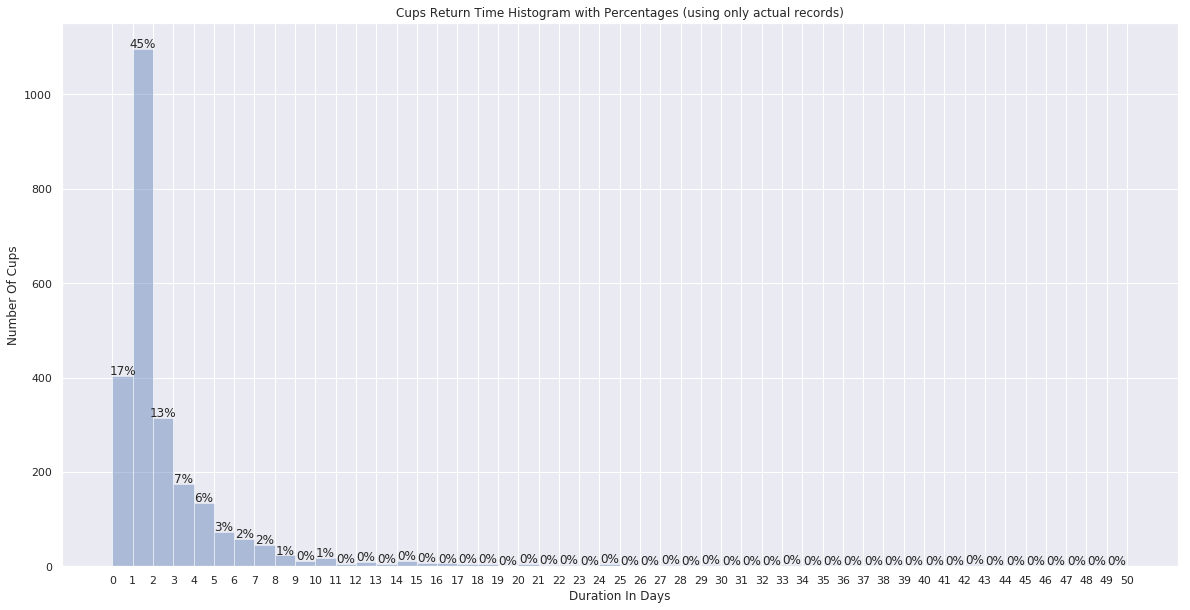

In [34]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
import math

#%matplotlib inline

sns.set(style="darkgrid")

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

# histogram plot
max_days_value = math.ceil(max(matchedDF['duration_in_days']))
sns.distplot(a=matchedDF['duration_in_days'], hist=True, kde=False, rug=False, bins=range(max_days_value))

# Setting the X and Y Label 
plt.xlabel('Duration In Days') 
plt.ylabel('Number Of Cups')

# setting the X and Y ticks
plt.xticks(np.arange(0, max_days_value))
# plt.yticks(np.arange(0, 750, 50))

# setting the title
plt.title('Cups Return Time Histogram with Percentages (using only actual records)')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1}%'.format(int(round(height/len(matchedDF)*100))),
            ha="center") 

plt.show()

### Taking both actual and fabricated records

In [27]:
fabricatedDF = df[(df['status'] == 3)]
fabricatedDF.loc[:, 'duration'] = abs(fabricatedDF.loc[:, 'linked_date_time'] - fabricatedDF.loc[:, 'date_time'])
fabricatedDF.loc[:, 'duration_in_days'] = fabricatedDF.loc[:, 'duration'] / np.timedelta64(1, 'D')
combinedDF = pd.concat([matchedDF, fabricatedDF], ignore_index=True)
combinedDF.duration_in_days.describe()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    4605.000000
mean        4.633899
std         4.928510
min         0.055313
25%         1.285405
50%         3.166817
75%         6.013391
max        50.194688
Name: duration_in_days, dtype: float64

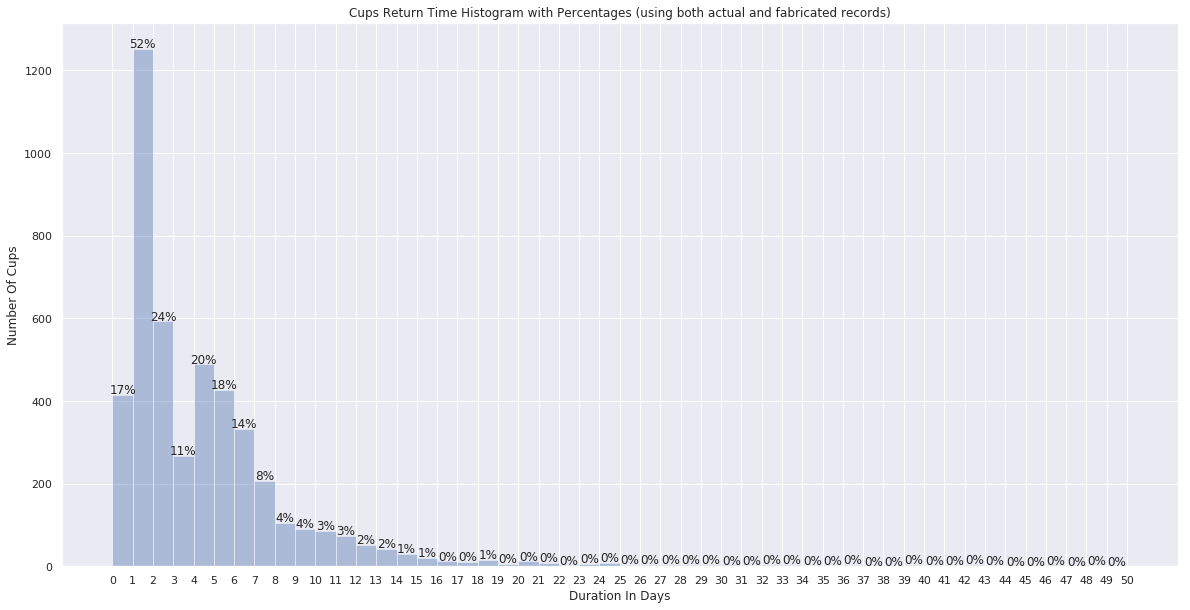

In [28]:
sns.set(style="darkgrid")

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

# histogram plot
max_days_value = math.ceil(max(combinedDF['duration_in_days']))
sns.distplot(a=combinedDF['duration_in_days'], hist=True, kde=False, rug=False, bins=range(max_days_value))

# Setting the X and Y Label 
plt.xlabel('Duration In Days') 
plt.ylabel('Number Of Cups')

# setting the X and Y ticks
plt.xticks(np.arange(0, max_days_value))
#plt.yticks(np.arange(0, 850, 50))

# setting the title
plt.title('Cups Return Time Histogram with Percentages (using both actual and fabricated records)')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1}%'.format(int(round(height/len(matchedDF)*100))),
            ha="center") 

plt.show()

## Cups Usage Analysis

### Number of times cups were used

In [29]:
timesUsedDF = df[df['status'] != 2].groupby('cup_id').size().reset_index(name='times_used')
timesUsedDF.head()

,cup_id,times_used
0,1008415089,9
1,1012822375,2
2,1017030777,5
3,1017492318,3
4,1019325282,3


In [30]:
total_cups = len(timesUsedDF['cup_id'])
numCupsByTimesUsedDF = timesUsedDF.groupby('times_used').size().reset_index(name='number_of_cups').sort_values(by='times_used', ascending=False)
numCupsByTimesUsedDF.loc[:, 'cumulative_total'] = numCupsByTimesUsedDF['number_of_cups'].cumsum(axis=0)
numCupsByTimesUsedDF.loc[:, 'percentage_of_cups'] = round(numCupsByTimesUsedDF['cumulative_total'] / total_cups * 100)
numCupsByTimesUsedDF

,times_used,number_of_cups,cumulative_total,percentage_of_cups
10,11,5,5,0.0
9,10,9,14,1.0
8,9,36,50,4.0
7,8,92,142,10.0
6,7,118,260,19.0
5,6,156,416,30.0
4,5,149,565,41.0
3,4,183,748,55.0
2,3,236,984,72.0
1,2,200,1184,86.0


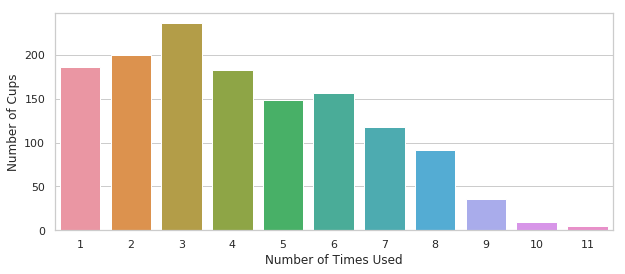

In [31]:
sns.set(style="whitegrid")

fig_dims = (10, 4)
fig, ax = plt.subplots(figsize=fig_dims)

ax1 = sns.barplot(x="times_used", y="number_of_cups", data=numCupsByTimesUsedDF, palette=sns.set_palette("husl"))
#ax2 = ax1.twinx()
#ax2 = sns.pointplot(x="times_used", y="percentage_of_cups", data=numCupsByTimesUsedDF, color='black')
ax1.set_xlabel('Number of Times Used')
ax1.set_ylabel('Number of Cups')
#ax2.set_ylabel('Percentage of Cups')

#ax2.grid(False)
plt.show()

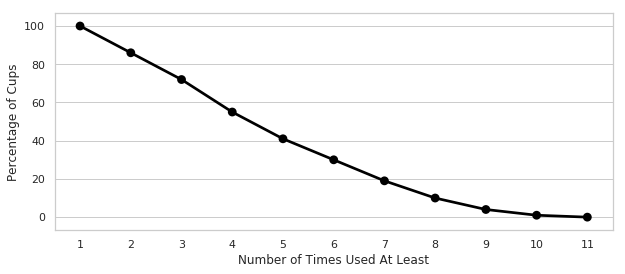

In [32]:
sns.set(style="whitegrid")

fig_dims = (10, 4)
fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.pointplot(x="times_used", y="percentage_of_cups", data=numCupsByTimesUsedDF, color='black')
ax.set_xlabel('Number of Times Used At Least')
ax.set_ylabel('Percentage of Cups')
plt.show()